# ResNet-Competition

__Author:Marcus Alsterman<br>
Name here [marals@kth.se](mailto:marals@kth.se)__

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random as rn
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train/255, X_test/255

Using TensorFlow backend.


In [2]:
# # seeding
# seed = 95
# np.random.seed(seed)
# rn.seed(seed + 1)
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
#                               inter_op_parallelism_threads=1)
# from keras import backend as K
# tf.set_random_seed(seed + 2)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [3]:
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, ReLU, Add, Flatten
from keras import optimizers
from keras import initializers
from keras.utils import to_categorical
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

pixel_count =  355


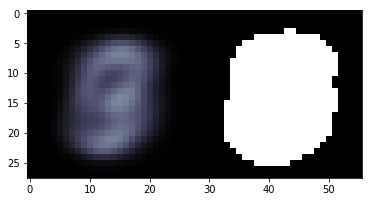

In [4]:
# data preprocessing
cutoff = 0.051
mean_train_image = np.mean(X_train, axis=0)
mean_train_image_cutoff = mean_train_image > cutoff
plt.imshow(np.concatenate((mean_train_image ,mean_train_image_cutoff), axis=1), clim=[0,1], cmap='bone')

pixel_count = np.sum(mean_train_image_cutoff)
print('pixel_count = ',pixel_count)

X_train = X_train[:, mean_train_image_cutoff]
X_test = X_test[:, mean_train_image_cutoff]

# one hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## MLP

In [5]:
x_in = Input(shape=(pixel_count,))
x = x_in
num_layers = 5
for i in range(0,num_layers):
    x = Dense(20, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

In [6]:
model = Model(inputs=[x_in], outputs= x)

In [7]:
model.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 355)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                7120      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
Total para

In [8]:
model.compile(optimizer='AdaGrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(X_train, y_train, epochs=50,
          validation_split=0.1,
          callbacks=[ES],
          shuffle=True)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 5s 84us/step - loss: 0.5081 - acc: 0.8452 - val_loss: 0.2892 - val_acc: 0.9178
Epoch 2/50
54000/54000 [==============================] - 4s 70us/step - loss: 0.3193 - acc: 0.9089 - val_loss: 0.2414 - val_acc: 0.9290
Epoch 3/50
54000/54000 [==============================] - 4s 70us/step - loss: 0.2799 - acc: 0.9209 - val_loss: 0.2164 - val_acc: 0.9355
Epoch 4/50
54000/54000 [==============================] - 4s 70us/step - loss: 0.2554 - acc: 0.9277 - val_loss: 0.1981 - val_acc: 0.9427
Epoch 5/50
54000/54000 [==============================] - 4s 69us/step - loss: 0.2371 - acc: 0.9322 - val_loss: 0.1855 - val_acc: 0.9475
Epoch 6/50
54000/54000 [==============================] - 4s 69us/step - loss: 0.2235 - acc: 0.9366 - val_loss: 0.1781 - val_acc: 0.9493
Epoch 7/50
54000/54000 [==============================] - 4s 70us/step - loss: 0.2129 - acc: 0.9397 - val_loss: 0.1709 - val_acc:

In [10]:
print('final accuracy MLP = ',model.evaluate(X_test, y_test)[1])

10000/10000 [==============================] - 0s 27us/step
final accuracy MLP =  0.9549


## ResNet

In [11]:
def dense_with_skip(x, dense):
    skip = x
    x = dense(x)
    x = Add()([x,skip])
    return x

In [12]:
def dense_factory(size=17):
    return Dense(size,
                 activation = 'relu',
                 kernel_initializer = initializers.RandomNormal(0.0, 0.01, seed=123),
                 bias_initializer = 'zero',
                 
                
                )
x_in = Input(shape=(pixel_count,))

x = dense_factory()(x_in)

num_layers_with_skip = 10
for i in range(0,num_layers_with_skip):
    x = dense_with_skip(x, dense_factory())

# output layer
x = Dense(10, activation='softmax')(x)

In [13]:
model = Model(inputs=[x_in], outputs= x)

In [14]:
model.summary();

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 355)          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 17)           6052        input_2[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 17)           306         dense_7[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 17)           0           dense_8[0][0]                    
                                                                 dense_7[0][0]                    
__________

In [15]:
model.compile(optimizer='AdaGrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.fit(X_train, y_train, epochs=500,
          validation_split=0.1,
          callbacks=[ES],
          shuffle=True)

Train on 54000 samples, validate on 6000 samples
Epoch 1/500
54000/54000 [==============================] - 9s 159us/step - loss: 0.3992 - acc: 0.8806 - val_loss: 0.2234 - val_acc: 0.9355
Epoch 2/500
54000/54000 [==============================] - 7s 124us/step - loss: 0.2437 - acc: 0.9283 - val_loss: 0.1993 - val_acc: 0.9410
Epoch 3/500
54000/54000 [==============================] - 7s 125us/step - loss: 0.2124 - acc: 0.9369 - val_loss: 0.1800 - val_acc: 0.9482
Epoch 4/500
54000/54000 [==============================] - 7s 124us/step - loss: 0.1950 - acc: 0.9420 - val_loss: 0.1615 - val_acc: 0.9538
Epoch 5/500
54000/54000 [==============================] - 7s 125us/step - loss: 0.1831 - acc: 0.9461 - val_loss: 0.1585 - val_acc: 0.9563
Epoch 6/500
54000/54000 [==============================] - 7s 125us/step - loss: 0.1752 - acc: 0.9479 - val_loss: 0.1550 - val_acc: 0.9540
Epoch 7/500
54000/54000 [==============================] - 74s 1ms/step - loss: 0.1682 - acc: 0.9501 - val_loss: 0.15

54000/54000 [==============================] - 7s 124us/step - loss: 0.0965 - acc: 0.9710 - val_loss: 0.1255 - val_acc: 0.9635
Epoch 60/500
54000/54000 [==============================] - 74s 1ms/step - loss: 0.0959 - acc: 0.9713 - val_loss: 0.1247 - val_acc: 0.9642
Epoch 61/500
54000/54000 [==============================] - 7s 125us/step - loss: 0.0955 - acc: 0.9711 - val_loss: 0.1244 - val_acc: 0.9630
Epoch 62/500
54000/54000 [==============================] - 7s 139us/step - loss: 0.0953 - acc: 0.9712 - val_loss: 0.1228 - val_acc: 0.9648
Epoch 63/500
54000/54000 [==============================] - 7s 124us/step - loss: 0.0948 - acc: 0.9716 - val_loss: 0.1226 - val_acc: 0.9657
Epoch 64/500
54000/54000 [==============================] - 7s 124us/step - loss: 0.0945 - acc: 0.9716 - val_loss: 0.1239 - val_acc: 0.9645
Epoch 65/500
54000/54000 [==============================] - 7s 124us/step - loss: 0.0942 - acc: 0.9718 - val_loss: 0.1242 - val_acc: 0.9638
Epoch 66/500
54000/54000 [========

In [17]:
print('final accuracy ResNet = ',model.evaluate(X_test, y_test)[1])

10000/10000 [==============================] - 0s 44us/step
final accuracy ResNet =  0.9595
